# MNIST test dataset 

In [1]:
'''Trains a simple convnet on the MNIST dataset.
Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imsave
import numpy as np
import time

Using TensorFlow backend.
/Users/cyrilwendl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data Import 
Import the data, delete all data in the training set of class 4 

In [2]:
# adapted from Source: https://github.com/keras-team/keras/tree/master/examples

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test_all, y_test_all) = mnist.load_data()
print(np.unique(y_train, return_counts=True))

label_to_remove = 7
    

# remove all trainig samples containing a label label_to_remove
x_train = x_train[y_train!=label_to_remove]
y_train = y_train[y_train!=label_to_remove]
    
x_test = x_test_all[y_test_all!=label_to_remove]
y_test = y_test_all[y_test_all!=label_to_remove]

# decrease all labels that are higher by -1 to avoid gaps
for i in range(label_to_remove+1, 11):
    y_train[y_train == i] = (i-1)
    y_test[y_test == i] = (i-1)
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 5851, 5949]))


In [3]:
batch_size = 128
num_classes = 9
epochs = 2 # TODO increase number of epochs

# input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Tensorflow
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
x_test_all = x_test_all.reshape(x_test_all.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_test_all = x_test_all.astype('float32')
x_train /= 255
x_test /= 255
x_test_all /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (53735, 28, 28, 1)
53735 train samples
8972 test samples


In [4]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

print(model.summary())
model_train = False;
if model_train:
    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
    model.save('mnist.h5')
else :
    model = load_model('mnist.h5')

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

#### Let's make some predictions for the unseen class

In [5]:
# all images in the test set containing a label label_to_remove
x_unseen_class = x_test_all[np.where(y_test_all==label_to_remove)[0]] 

# make prodictions for class unseen during training
y_pred = model.predict(x_unseen_class)
y_pred_label = np.argmax(y_pred, axis = 1);

for i in range(label_to_remove, 9):
    y_pred_label[y_pred_label == i] = (i+1)

# distribution of predicted label
pred_labels, pred_counts = np.unique(y_pred_label,return_counts=True)

import pandas as pd
df = pd.DataFrame({'label': pred_labels, 'count': pred_counts},columns=['label','count'])
df.set_index('label',inplace=True)
print("Predicted labels:")
display(df.T)

Predicted labels:


label,0,1,2,3,4,5,9
count,5,19,199,219,20,1,565


In [6]:
# Avarage certitude: 1-max_margin
c = []
for i in range(len(y_pred_label)):
    y_probas = np.sort(y_pred[i])  # probabilities for one image
    c.append(y_probas[-1]-y_probas[-2])  # margin

    
pred_acc_mean = np.mean(c)
pred_acc_std = np.std(c)
    
print("Mean accuracy: " + str(pred_acc_mean))
print("Std. accuracy: " + str(pred_acc_std))

c = np.asarray(c)
pred_acc_high = pred_acc_std+pred_acc_mean


pct = np.round(len(c[c>pred_acc_high])/len(c),4)*100
print("%.2f%% of all predictions made with an accuracy higher than %.2f%%" % (pct, pred_acc_high))

Mean accuracy: 0.606905
Std. accuracy: 0.327538
24.42% of all predictions made with an accuracy higher than 0.93%


# Activation weights visualization

In [7]:
# from https://github.com/keras-team/keras/issues/41

from keras import backend as K
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return activations

(1, 1, 24, 24, 64)


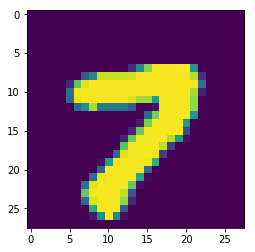

In [8]:
ind_im_test = 10
activations = get_activations(model, 1, x_unseen_class[ind_im_test][np.newaxis,:,:,:])
print(np.shape(activations))
plt.imshow(x_unseen_class[ind_im_test][:,:,0])
plt.show()

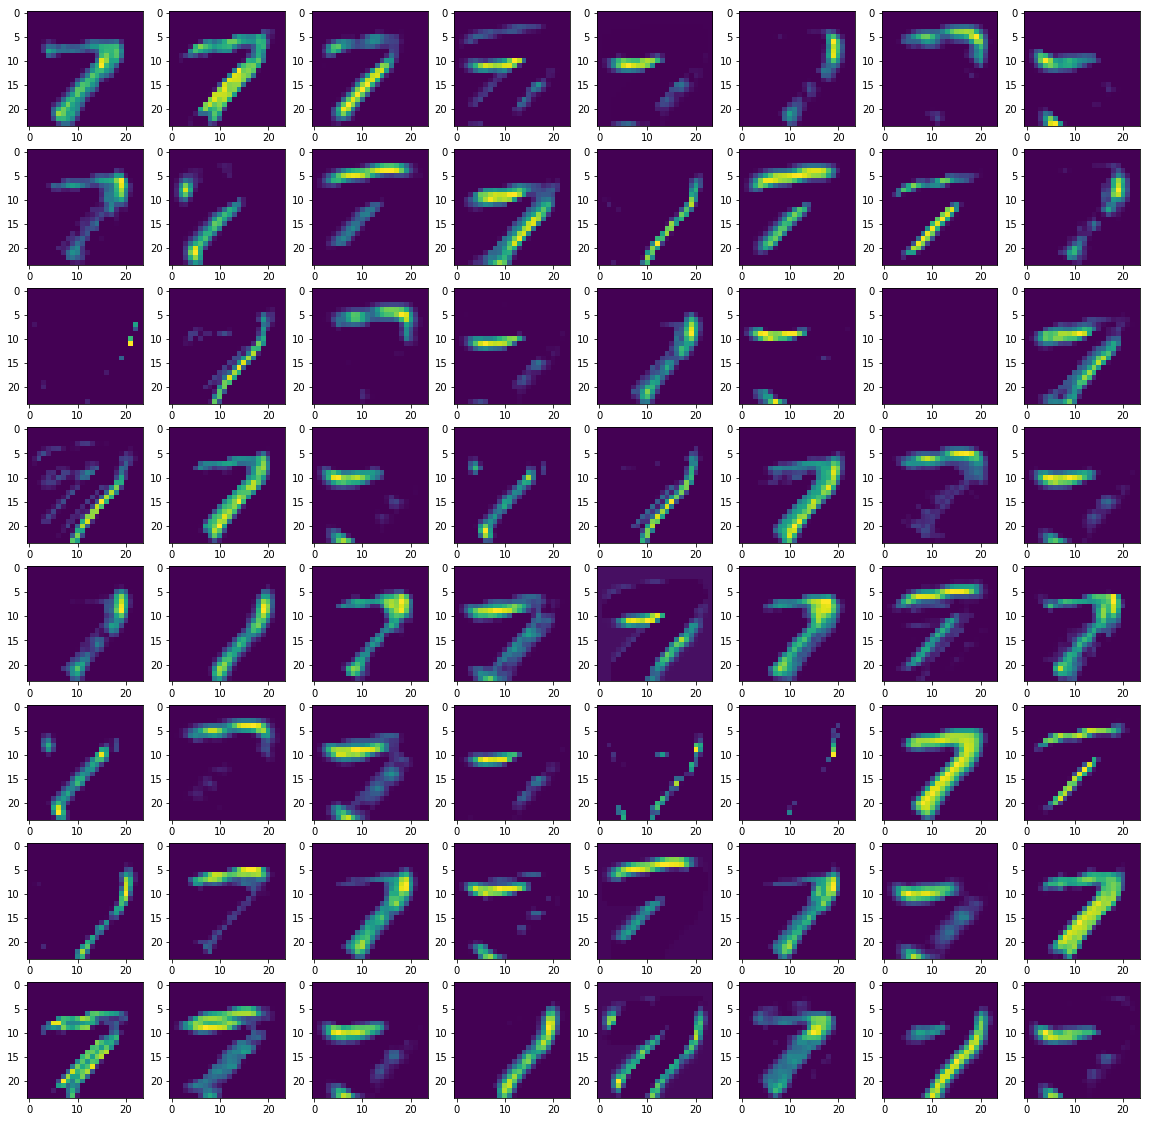

In [9]:
fig, axes = plt.subplots(8,8)
fig.set_size_inches(20,20)
for i in range(8):
    for j in range(8):
        axes[i][j].imshow(activations[0][0][:,:,i*8+j])
plt.show()

In [10]:
y_test = np.argmax(y_test, axis = 1)

In [11]:
# get activation weights of last layer
activations_unseen_class = get_activations(model, 6, x_unseen_class)[0]
print(np.shape(activations_unseen_class))

activations_seen_classes = get_activations(model, 6, x_test[:500])[0]
print(np.shape(activations_seen_classes))

(1028, 128)
(500, 128)


In [12]:
for i in range(9): # loop classes
    # get vectors 
    pass


act_cl_1 = activations_seen_classes[np.where(y_test[:500] == 1)[0],:] # cluster 1
act_cl_2 = activations_seen_classes[np.where(y_test[:500] == 2)[0],:] # cluster 2, etc.
act_cl_3 = activations_seen_classes[np.where(y_test[:500] == 3)[0],:] # cluster 2, etc.
act_cl_4 = activations_seen_classes[np.where(y_test[:500] == 4)[0],:] # cluster 2, etc.
act_cl_5 = activations_seen_classes[np.where(y_test[:500] == 5)[0],:] # cluster 2, etc.
act_cl_6 = activations_seen_classes[np.where(y_test[:500] == 6)[0],:] # cluster 2, etc.
act_cl_7 = activations_seen_classes[np.where(y_test[:500] == 7)[0],:] # cluster 2, etc.

# ...

print(act_cl_2.shape)

(63, 128)


# Density Tree
Feed activation weigths into density tree

In [13]:
from density_tree.decision_tree_create import *
from density_tree.density_tree_create import *
from density_tree.density_tree import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *

In [18]:
# create density tree for activation weights of training data

dimensions = activations_seen_classes.shape[1]
nclusters = 9

from sklearn import decomposition

np.linalg.det(np.cov(act_cl_1.T))

# PCA
plt.cla()
pca = decomposition.PCA(n_components=20)
pca.fit(activations_seen_classes)
X = pca.transform(activations_seen_classes)

root = create_density_tree(X, dimensions = dimensions, clusters = nclusters)

Creating new node


/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/cyrilwendl/Documents/EPFL/SIE-Project/Code/density_tree/helpers.py:23: RuntimeWarning: Degrees of freedom <= 0 for slice
  k = np.linalg.det(np.cov(dataset.T))
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = 

54.7482036962
Creating new node
46.422121267
Creating new node
46.7513223132
Creating new node
46.7000061761
Creating new node
45.9515757722
Creating new node
45.4745431643
Creating new node
45.1501622845
Creating new node


In [ ]:
# descend tree for each act_cl_1...act_cl_7 and check whether they end up in the same root nodes or not


def descend_decision_tree(data_point, node):
    """given some test data and decision tree, assign a node of the density tree to the point"""

    # check left or right side
    if data_point[node.split_dimension] < node.split_value:  # split to the left
        if len(node.left_labels) == 1:  # if there is only one label, return it
            return int(node.left_labels)
        return descend_decision_tree(data_point, node.left)
    else:  # split to the right
        if len(node.right_labels) == 1:  # if there is only one label, return it
            return int(node.right_labels)
        return descend_decision_tree(data_point, node.right)


def descend_decision_tree_aux(dataset, root):
    """for all data points, predict a final node"""
    dataset_eval = []
    for i in dataset:  # loop all data points
        # get labels
        label = descend_decision_tree(i, root)
        # append to dataset
        dataset_eval.append(np.concatenate([i, [label]]))

    dataset_eval = np.asarray(dataset_eval)
    return dataset_eval
